In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split



2024-04-28 11:19:40.379338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 11:19:47.087253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/Anaconda/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


In [21]:
data = pd.read_csv("train.csv")

import spacy

# Cargar el modelo de idioma inglés de spaCy
nlp = spacy.load("en_core_web_sm") 

# Función para preprocesar el texto
def preprocess_text(text):
    # Tokenización y lematización
    doc = nlp(text)
    tokens_lemmatized = [token.lemma_ for token in doc] 
    
    # Eliminación de stopwords y caracteres especiales
    clean_tokens = [token.lower() for token in tokens_lemmatized
                    if not nlp.vocab[token].is_stop 
                    and nlp.vocab[token].is_oov
                    and not nlp.vocab[token].is_punct
                    and token.isalpha 
                   ]
    
    # Unir los tokens limpios en una cadena de texto nuevamente
    clean_text = " ".join(clean_tokens)
    
    return clean_text

# Cargar los datos
data = pd.read_csv("train.csv")

# Aplicar el preprocesamiento al texto
#data=data[0:50]
data['clean_text'] = data['text'].apply(preprocess_text)
data.head()

In [50]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_texts = train_data['clean_text'].values
train_labels = train_data['label'].values
test_texts = test_data['clean_text'].values
test_labels = test_data['label'].values

In [51]:
BUFFER_SIZE = 2000
BATCH_SIZE = 4

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [53]:
VOCAB_SIZE = 100000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


2024-04-28 12:22:03.594797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [61]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [62]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True, True, True]


In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-6),
              metrics=['accuracy'])


In [137]:
history = model.fit(train_dataset, epochs=1, #90
                    validation_data=test_dataset,
                    validation_steps=200)


1630/1630 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.9682 - loss: 0.0826 - val_accuracy: 0.7638 - val_loss: 2.4732


In [138]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7608 - loss: 2.5147
Test Loss: 2.7870757579803467
Test Accuracy: 0.7319018244743347


(0.0, 2.769912466406822)

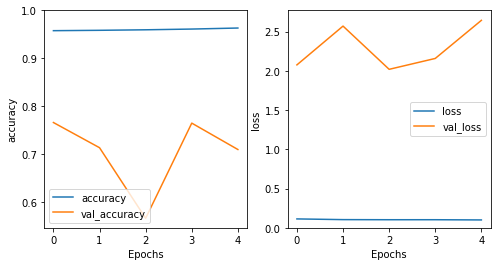

In [128]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [129]:
# Cargar el conjunto de datos test
test_data = pd.read_csv("test_nolabel.csv")

test_data

,text,id
0,Well media selected them exactly because they'...,ce40fcb3a33
1,We must stand together to return this mass of ...,02ca950343c
2,http://apologeticspress.org/APContent.aspx?cat...,a59e88b4f9c
3,"The UK has universal healthcare you dickwad, t...",ad62d80af38
4,Is that comment good for clergyman Paul Kosyl?,a6b36372f05
...,...,...
3488,This political party were neo-nazis in the 90s...,c42316663f5
3489,You're fucking kidding me. I'm stupefied she i...,3e1b52d2030
3490,Instead of caricaturing the whole Muslim and I...,fe66fe0f5cc
3491,"sort out Is , and then they can go back!!!",3a5ca8a8fd5


In [130]:
# Aplicar el preprocesamiento al texto
test_data['clean_text'] = test_data['text'].apply(preprocess_text)
test_data[0:5]

,text,id,clean_text
0,Well media selected them exactly because they'...,ce40fcb3a33,medium select exactly stupid ignorant level sa...
1,We must stand together to return this mass of ...,02ca950343c,stand return mass people come need stand gover...
2,http://apologeticspress.org/APContent.aspx?cat...,a59e88b4f9c,http://apologeticspress.org/apcontent.aspx?cat...
3,"The UK has universal healthcare you dickwad, t...",ad62d80af38,uk universal healthcare dickwad medical cost c...
4,Is that comment good for clergyman Paul Kosyl?,a6b36372f05,comment good clergyman paul kosyl


In [131]:
#Predicción
pred_new = model.predict(test_data["clean_text"])

# Aplicar umbral para convertir las probabilidades en etiquetas binarias
binary_predictions = (pred_new > 0.5).astype(int)

# Añadir las predicciones binarias al DataFrame
test_data['predicted_label'] = binary_predictions

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [132]:
predictions_df = pd.DataFrame({'id': test_data["id"], 'label': test_data['predicted_label']})

predictions_df.to_csv("RNN_predictions.csv", index=False, header=True)
predictions_df

,id,label
0,ce40fcb3a33,1
1,02ca950343c,1
2,a59e88b4f9c,0
3,ad62d80af38,0
4,a6b36372f05,0
...,...,...
3488,c42316663f5,1
3489,3e1b52d2030,1
3490,fe66fe0f5cc,0
3491,3a5ca8a8fd5,0
